#### Problème 2:

Utilisez le modèle d’arbre de décision CART pour l’approximation de la consommation énergétique d’une maison à partir d’un ensemble de données de prévision énergétique des appareils électroménagers.

Réalisée par : Imane Hilali, Mohamed Ben Jouad, Reda Ghadouani

In [1]:
import pandas as pd
import numpy as np

## Charger les  données Titanic à partir d'un fichier CSV
data = pd.read_csv("C:\\Users\\dell i7 8 5500\\Downloads\\Appliances_energy\\energydata_complete.csv")

print(data.head())


                  date  Appliances  lights     T1       RH_1    T2       RH_2   
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000  \
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3  2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
4  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9     T_out  Press_mm_hg   
0  19.79  44.730000  19.000000  ...  17.033333  45.53  6.600000        733.5  \
1  19.79  44.790000  19.000000  ...  17.066667  45.56  6.483333        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50  6.366667        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40  6.250000        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40  6.133333        733.9   

   RH_out  Windspeed  Visibility

In [4]:
import pandas as pd

data['date'] = pd.to_datetime(data['date'])  # Convert the column to datetime format

# Extract relevant features
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['minute'] = data['date'].dt.minute

# Drop the original date_time column if desired
data.drop('date', axis=1, inplace=True)


La classe Node représente les nœuds de l'arbre de décision.
Chaque nœud peut être un nœud de décision (avec des attributs tels que feature_index, threshold, left, right, var_red)
ou un nœud feuille (avec l'attribut value qui représente la valeur de prédiction).

In [5]:
#Constructor for the Node class
class Node:
    def __init__(self,feature_index=None,threshold=None,left=None,right=None,var_red=None,value=None):
        # For decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        # For leaf node
        self.value = value

La classe DecisionTreeRegressor représente le modèle de régression par arbre de décision.
Elle contient les méthodes et attributs nécessaires pour construire et utiliser l'arbre de décision.

In [6]:
class DecisionTreeRegressor:
    # Constructor for the DecisionTreeRegressor class
    def __init__(self, min_samples_split=2, max_depth=2):
        # Initialize the root of the tree
        self.root = None
        # Stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    #La méthode build_tree est une fonction récursive qui construit l'arbre de décision en utilisant les données d'entraînement X et les valeurs cibles Y. Elle divise récursivement les données en fonction des critères de division (meilleur split) jusqu'à ce que les conditions d'arrêt soient atteintes (nombre minimal d'échantillons ou profondeur maximale de l'arbre).
    def build_tree(self, X, Y, curr_depth=0):
        num_samples, num_features = X.shape
        best_split = {}
        # Split until stopping conditions are met

        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:
            best_split = self.get_best_split(X, Y, num_samples, num_features)

            # Check if variance reduction is positive
            if best_split['var_red'] > 0:
                # Recur left
                left_subtree = self.build_tree(best_split['X_left'], best_split['Y_left'], curr_depth + 1)
                # Recur right
                right_subtree = self.build_tree(best_split['X_right'], best_split['Y_right'], curr_depth + 1)
                # Return decision node
                return Node(best_split['feature_index'], best_split['threshold'], left_subtree, right_subtree, best_split['var_red'])

        # Compute leaf node
        leaf_value = np.mean(Y)
        # Return leaf node
        return Node(value=leaf_value)

    #La méthode get_best_split est utilisée pour trouver le meilleur critère de division (meilleur split) en parcourant toutes les caractéristiques et tous les seuils possibles. Elle utilise la mesure de réduction de variance pour évaluer la qualité de chaque split.
    # Function to find the best split
    def get_best_split(self, X, Y, num_samples, num_features):

        best_split = {}
        max_var_red = -float('inf')

        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            unique_thresholds = np.unique(feature_values)

            for threshold in unique_thresholds:
                X_left, Y_left, X_right, Y_right = self.split(X, Y, feature_index, threshold)

                if len(X_left) > 0 and len(X_right) > 0:
                    curr_var_red = self.variance_reduction(Y, Y_left, Y_right)

                    if curr_var_red > max_var_red:
                        best_split['feature_index'] = feature_index
                        best_split['threshold'] = threshold
                        best_split['X_left'] = X_left
                        best_split['Y_left'] = Y_left
                        best_split['X_right'] = X_right
                        best_split['Y_right'] = Y_right
                        best_split['var_red'] = curr_var_red
                        max_var_red = curr_var_red

        return best_split

    #La méthode split est utilisée pour diviser les données en deux sous-ensembles en fonction d'un critère de division spécifique (caractéristique et seuil).
    # Function to split the data
    def split(self, X, Y, feature_index, threshold):
        mask = X[:, feature_index] <= threshold
        X_left = X[mask]
        Y_left = Y[mask]
        X_right = X[~mask]
        Y_right = Y[~mask]

        return X_left, Y_left, X_right, Y_right

    #La méthode variance_reduction est utilisée pour calculer la réduction de variance lors de la division des données en deux sous-ensembles.
    # Function to compute variance reduction
    def variance_reduction(self, parent, left_child, right_child):

        weight_l = len(left_child) / len(parent)
        weight_r = len(right_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(left_child) + weight_r * np.var(right_child))

        return reduction

    #La méthode print_tree est utilisée pour afficher l'arbre de décision à l'écran. Elle parcourt récursivement l'arbre en utilisant un indent pour représenter les niveaux de profondeur.
    # Function to print the tree
    def print_tree(self, tree=None, indent=''):

        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)
        else:
            print(f'X_{tree.feature_index} <= {tree.threshold} ? {tree.var_red}')
            print(f'{indent}left:', end='')
            self.print_tree(tree.left, indent + '    ')
            print(f'{indent}right:', end='')
            self.print_tree(tree.right, indent + '    ')

    # La méthode fit est utilisée pour entraîner le modèle en construisant l'arbre de décision à partir des données d'entraînement.
    # Function to train the tree
    def fit(self, X, Y):
        self.root = self.build_tree(X, Y)

    #La méthode make_prediction est utilisée pour prédire la valeur cible d'un nouvel exemple en parcourant l'arbre de décision à partir de la racine.
    # Function to predict a new data point
    def make_prediction(self, x, tree):

        if tree.value is not None:
            return tree.value

        feature_val = x[tree.feature_index]

        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

    #La méthode predict est utilisée pour prédire les valeurs cibles pour plusieurs exemples en utilisant la méthode make_prediction.
    # Function to predict for multiple data points
    def predict(self, X):
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions


In [7]:
# Separating independent variables (features) and dependent variable (target)
X = data.drop(['Appliances'], axis=1)  # Independent variables
y = data['Appliances']  # Dependent variable

X1 = X.iloc[:, :-1].values
Y1 = y.values.reshape(-1, 1)  # Reshape y to have a 2D shape

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1, test_size=0.2, random_state=41)


In [ ]:
regressor = DecisionTreeRegressor(min_samples_split=5, max_depth=3)
regressor.fit(X_train,Y_train)
regressor.print_tree()

In [17]:
#make predictions
Y_pred = regressor.predict(X_test)

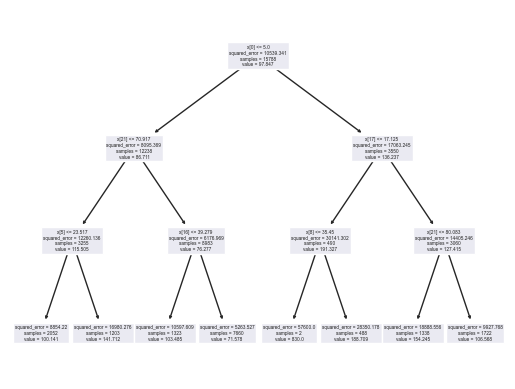

In [27]:
from sklearn import tree
from matplotlib import pyplot as plt

regressor1 = DecisionTreeRegressor(min_samples_split=3, max_depth=3)
regressor1.fit(X_train,Y_train)
tree.plot_tree(regressor1)
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(Y_test, Y_pred))

95.12377921863644

le MSE est égal à 95.12377921863644. Cela signifie que, en moyenne, les prédictions de votre modèle ont une erreur quadratique de 95.12 par rapport aux valeurs réelles de la variable cible. Un MSE élevé indique une performance médiocre du modèle, car les erreurs sont importantes.

In [29]:
from sklearn.metrics import r2_score

r2 = r2_score(Y_test, Y_pred)
print("R2 Score:", r2)

R2 Score: 0.12963689113069954


Le R-squared est égal à 0.12963689113069954, ce qui suggère que votre modèle explique seulement environ 12.96% de la variance totale des données. Cela indique une faible adéquation du modèle aux données, car une grande partie de la variance reste non expliquée.